In [ ]:
%matplotlib inline


# Multi-class AdaBoosted Decision Trees

This example reproduces Figure 1 of Zhu et al [1]_ and shows how boosting can
improve prediction accuracy on a multi-class problem. The classification
dataset is constructed by taking a ten-dimensional standard normal distribution
and defining three classes separated by nested concentric ten-dimensional
spheres such that roughly equal numbers of samples are in each class (quantiles
of the $\chi^2$ distribution).

The performance of the SAMME and SAMME.R [1]_ algorithms are compared. SAMME.R
uses the probability estimates to update the additive model, while SAMME  uses
the classifications only. As the example illustrates, the SAMME.R algorithm
typically converges faster than SAMME, achieving a lower test error with fewer
boosting iterations. The error of each algorithm on the test set after each
boosting iteration is shown on the left, the classification error on the test
set of each tree is shown in the middle, and the boost weight of each tree is
shown on the right. All trees have a weight of one in the SAMME.R algorithm and
therefore are not shown.

.. [1] J. Zhu, H. Zou, S. Rosset, T. Hastie, "Multi-class AdaBoost", 2009.


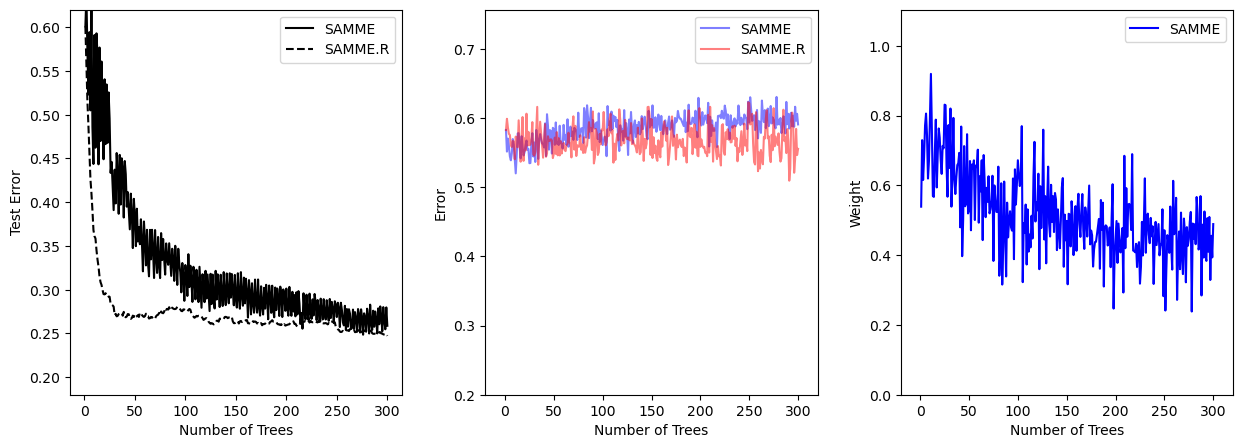

In [1]:
# Author: Noel Dawe <noel.dawe@gmail.com>
#
# License: BSD 3 clause

import matplotlib.pyplot as plt

from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier


X, y = make_gaussian_quantiles(
    n_samples=13000, n_features=10, n_classes=3, random_state=1
)

n_split = 3000

X_train, X_test = X[:n_split], X[n_split:]
y_train, y_test = y[:n_split], y[n_split:]

bdt_real = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2), n_estimators=300, learning_rate=1
)

bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=300,
    learning_rate=1.5,
    algorithm="SAMME",
)

bdt_real.fit(X_train, y_train)
bdt_discrete.fit(X_train, y_train)

real_test_errors = []
discrete_test_errors = []

for real_test_predict, discrete_test_predict in zip(
    bdt_real.staged_predict(X_test), bdt_discrete.staged_predict(X_test)
):
    real_test_errors.append(1.0 - accuracy_score(real_test_predict, y_test))
    discrete_test_errors.append(1.0 - accuracy_score(discrete_test_predict, y_test))

n_trees_discrete = len(bdt_discrete)
n_trees_real = len(bdt_real)

# Boosting might terminate early, but the following arrays are always
# n_estimators long. We crop them to the actual number of trees here:
discrete_estimator_errors = bdt_discrete.estimator_errors_[:n_trees_discrete]
real_estimator_errors = bdt_real.estimator_errors_[:n_trees_real]
discrete_estimator_weights = bdt_discrete.estimator_weights_[:n_trees_discrete]

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(range(1, n_trees_discrete + 1), discrete_test_errors, c="black", label="SAMME")
plt.plot(
    range(1, n_trees_real + 1),
    real_test_errors,
    c="black",
    linestyle="dashed",
    label="SAMME.R",
)
plt.legend()
plt.ylim(0.18, 0.62)
plt.ylabel("Test Error")
plt.xlabel("Number of Trees")

plt.subplot(132)
plt.plot(
    range(1, n_trees_discrete + 1),
    discrete_estimator_errors,
    "b",
    label="SAMME",
    alpha=0.5,
)
plt.plot(
    range(1, n_trees_real + 1), real_estimator_errors, "r", label="SAMME.R", alpha=0.5
)
plt.legend()
plt.ylabel("Error")
plt.xlabel("Number of Trees")
plt.ylim((0.2, max(real_estimator_errors.max(), discrete_estimator_errors.max()) * 1.2))
plt.xlim((-20, len(bdt_discrete) + 20))

plt.subplot(133)
plt.plot(range(1, n_trees_discrete + 1), discrete_estimator_weights, "b", label="SAMME")
plt.legend()
plt.ylabel("Weight")
plt.xlabel("Number of Trees")
plt.ylim((0, discrete_estimator_weights.max() * 1.2))
plt.xlim((-20, n_trees_discrete + 20))

# prevent overlapping y-axis labels
plt.subplots_adjust(wspace=0.25)
plt.show()